In [134]:
import os
import re
import subprocess
from collections import defaultdict
import numpy as np
import rasterio
from rasterio.merge import merge
from rasterio.warp import reproject, Resampling
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import glob
import json
from tqdm import tqdm

#import geopandas as gpd
import pandas as pd

import torch

import sys
sys.path.append('../')

import utils.basics as bsc 
import utils.plotting as pt
import utils.processing as proc
import utils.eval as eval

import utils.model_loader as md

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1st experiment: BASELINE

In [ ]:
# SELECT EXPERIMENTAL CONFIG
sites, cfg = get_config("baseline")  
global_config = md.global_config

In [ ]:
# Build dataset
X, Y = build_patched_dataset(cfg, sites, patch_size=32)
# split into train/val/test (70/15/15) with your logic
(X_train, Y_train), (X_val, Y_val), (X_test, Y_test) = split_dataset(X, Y)

# Syntax: X_train, X_val, X_test, y_train, y_val, y_test 
train_dataset = md.S2CanopyHeightDataset(X_train, Y_train)
val_dataset = S2CanopyHeightDataset(X_val, Y_val)
test_dataset = S2CanopyHeightDataset(X_test, Y_test)

train_loader = DataLoader(train_dataset, batch_size=global_config['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=global_config['batch_size'])
test_loader = DataLoader(test_dataset, batch_size=global_config['batch_size'])

In [146]:
# build model depending on in out channels, defined by the dataloaders
model = md.build_unet(in_channels=X[0].shape[0], out_channels=Y[0].shape[0])
#train model depending on config. 
model, logs = md.train_model(model, train_loader, val_loader, cfg, md.global_config)

Epochs: 100%|██████████| 150/150 [01:46<00:00,  1.41it/s]


In [148]:
md.save_results(model, logs, cfg)

Results saved to: ../results/train/baseline


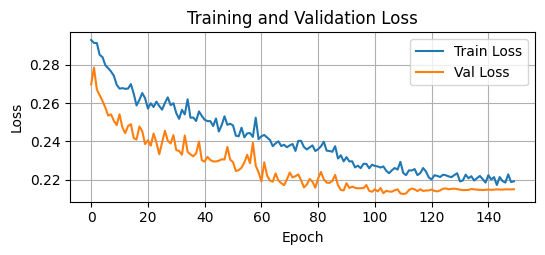

In [147]:
eval.plot_val_loss(logs['train_loss'],logs['val_loss'])

## 2nd Experiment: + PIXEL COMPOSITES Q25, Q50, Q75

In [149]:
# SELECT EXPERIMENTAL CONFIG
sites, cfg = get_config("pixel_composites")  
global_config = md.global_config

# Build dataset
X, Y = build_patched_dataset(cfg, sites, patch_size=32)
# split into train/val/test (70/15/15) with your logic
(X_train, Y_train), (X_val, Y_val), (X_test, Y_test) = split_dataset(X, Y)

# Syntax: X_train, X_val, X_test, y_train, y_val, y_test 
train_dataset = md.S2CanopyHeightDataset(X_train, Y_train)
val_dataset = S2CanopyHeightDataset(X_val, Y_val)
test_dataset = S2CanopyHeightDataset(X_test, Y_test)

train_loader = DataLoader(train_dataset, batch_size=global_config['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=global_config['batch_size'])
test_loader = DataLoader(test_dataset, batch_size=global_config['batch_size'])

# build model depending on in out channels, defined by the dataloaders
model = md.build_unet(in_channels=X[0].shape[0], out_channels=Y[0].shape[0])
#train model depending on config. 
model, logs = md.train_model(model, train_loader, val_loader, cfg, md.global_config)

Epochs: 100%|██████████| 150/150 [02:34<00:00,  1.03s/it]


Results saved to: ../results/train/pixel_composites


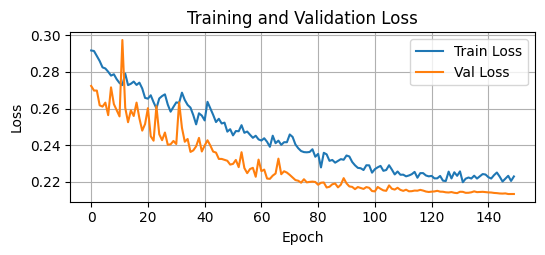

In [150]:
md.save_results(model, logs, cfg)
eval.plot_val_loss(logs['train_loss'],logs['val_loss'])


In [151]:
print("Minimum Validation Loss: ", min(logs['val_loss']))

Minimum Validation Loss:  0.2132713171568784


In [152]:
X.shape

(1172, 40, 32, 32)

## 3rd experiment: seasonal_composites

In [153]:
# SELECT EXPERIMENTAL CONFIG
sites, cfg = get_config("seasonal_composites")  
global_config = md.global_config

# Build dataset
X, Y = build_patched_dataset(cfg, sites, patch_size=32)
# split into train/val/test (70/15/15) with your logic
(X_train, Y_train), (X_val, Y_val), (X_test, Y_test) = split_dataset(X, Y)

# Syntax: X_train, X_val, X_test, y_train, y_val, y_test 
train_dataset = md.S2CanopyHeightDataset(X_train, Y_train)
val_dataset = md.S2CanopyHeightDataset(X_val, Y_val)
test_dataset = md.S2CanopyHeightDataset(X_test, Y_test)

train_loader = DataLoader(train_dataset, batch_size=global_config['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=global_config['batch_size'])
test_loader = DataLoader(test_dataset, batch_size=global_config['batch_size'])

# build model depending on in out channels, defined by the dataloaders
model = md.build_unet(in_channels=X[0].shape[0], out_channels=Y[0].shape[0])
#train model depending on config. 
model, logs = md.train_model(model, train_loader, val_loader, cfg, md.global_config)

Epochs: 100%|██████████| 150/150 [02:33<00:00,  1.02s/it]


Results saved to: ../results/train/seasonal_composites


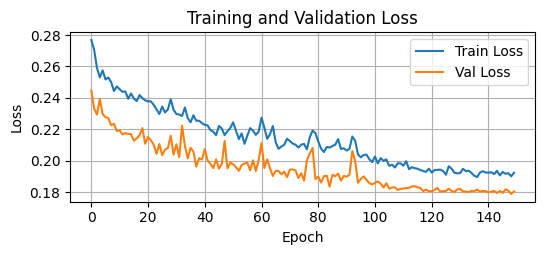

Minimum Validation Loss:  0.17872493618573898


In [ ]:
md.save_results(model, logs, cfg)
eval.plot_val_loss(logs['train_loss'],logs['val_loss'])
print("Minimum Validation Loss: ", min(logs['val_loss']))

## 4th experiment: pixel_and_seasonal

In [155]:
# SELECT EXPERIMENTAL CONFIG
sites, cfg = get_config("pixel_and_seasonal")  
global_config = md.global_config

print("Loading dataset...")
# Build dataset
X, Y = build_patched_dataset(cfg, sites, patch_size=32)
# split into train/val/test (70/15/15) with your logic
(X_train, Y_train), (X_val, Y_val), (X_test, Y_test) = split_dataset(X, Y)

print("Building data-loaders...")
# Syntax: X_train, X_val, X_test, y_train, y_val, y_test 
train_dataset = md.S2CanopyHeightDataset(X_train, Y_train)
val_dataset = md.S2CanopyHeightDataset(X_val, Y_val)
test_dataset = md.S2CanopyHeightDataset(X_test, Y_test)

train_loader = DataLoader(train_dataset, batch_size=global_config['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=global_config['batch_size'])
test_loader = DataLoader(test_dataset, batch_size=global_config['batch_size'])

print("Training ...")
# build model depending on in out channels, defined by the dataloaders
model = md.build_unet(in_channels=X[0].shape[0], out_channels=Y[0].shape[0])
#train model depending on config. 
model, logs = md.train_model(model, train_loader, val_loader, cfg, md.global_config)

Loading dataset...
Building data-loaders...
Training ...


Epochs: 100%|██████████| 150/150 [02:43<00:00,  1.09s/it]


Results saved to: ../results/train/pixel_and_seasonal


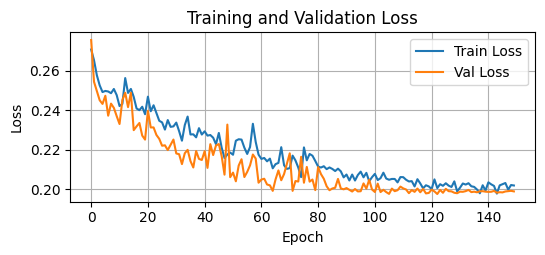

Minimum Validation Loss:  0.19751727198943114


In [156]:
md.save_results(model, logs, cfg)
eval.plot_val_loss(logs['train_loss'],logs['val_loss'])
print("Minimum Validation Loss: ", min(logs['val_loss']))

## 5th experiment: pixel_and_seasonal + all aux

In [157]:
# SELECT EXPERIMENTAL CONFIG
sites, cfg = get_config("all_aux_data")  
global_config = md.global_config

print("Loading dataset...")
# Build dataset
X, Y = build_patched_dataset(cfg, sites, patch_size=32)
# split into train/val/test (70/15/15) with your logic
(X_train, Y_train), (X_val, Y_val), (X_test, Y_test) = split_dataset(X, Y)

print("Building data-loaders...")
# Syntax: X_train, X_val, X_test, y_train, y_val, y_test 
train_dataset = md.S2CanopyHeightDataset(X_train, Y_train)
val_dataset = md.S2CanopyHeightDataset(X_val, Y_val)
test_dataset = md.S2CanopyHeightDataset(X_test, Y_test)

train_loader = DataLoader(train_dataset, batch_size=global_config['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=global_config['batch_size'])
test_loader = DataLoader(test_dataset, batch_size=global_config['batch_size'])

print("Training ...")
# build model depending on in out channels, defined by the dataloaders
model = md.build_unet(in_channels=X[0].shape[0], out_channels=Y[0].shape[0])
#train model depending on config. 
model, logs = md.train_model(model, train_loader, val_loader, cfg, md.global_config)

Loading dataset...
Building data-loaders...
Training ...


Epochs: 100%|██████████| 150/150 [02:40<00:00,  1.07s/it]


Results saved to: ../results/train/all_aux_data


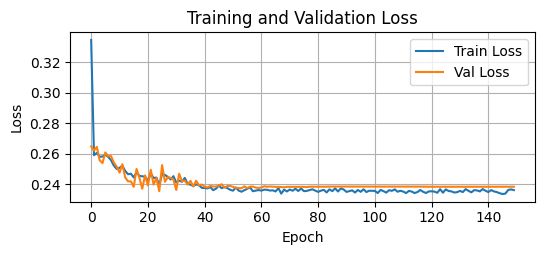

Minimum Validation Loss:  0.23547424108554155


In [158]:
md.save_results(model, logs, cfg)
eval.plot_val_loss(logs['train_loss'],logs['val_loss'])
print("Minimum Validation Loss: ", min(logs['val_loss']))

## 6th experiment: Mid-Level-Learning

In [ ]:
# SELECT EXPERIMENTAL CONFIG
sites, cfg = get_config("mid_level_learning")  
global_config = md.global_config

print("Loading dataset...")
# Build dataset
X, Y = build_patched_dataset(cfg, sites, patch_size=32)
# split into train/val/test (70/15/15) with your logic
(X_train, Y_train), (X_val, Y_val), (X_test, Y_test) = split_dataset(X, Y)

print("Building data-loaders...")
# Syntax: X_train, X_val, X_test, y_train, y_val, y_test 
train_dataset = md.S2CanopyHeightDataset(X_train, Y_train)
val_dataset = md.S2CanopyHeightDataset(X_val, Y_val)
test_dataset = md.S2CanopyHeightDataset(X_test, Y_test)

train_loader = DataLoader(train_dataset, batch_size=global_config['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=global_config['batch_size'])
test_loader = DataLoader(test_dataset, batch_size=global_config['batch_size'])

print("Training ...")
# build model depending on in out channels, defined by the dataloaders
model = md.build_unet(in_channels=X[0].shape[0], out_channels=Y[0].shape[0])
#train model depending on config. 
model, logs = md.train_model(model, train_loader, val_loader, cfg, md.global_config)

Results saved to: ../results/train/mid_level_learning


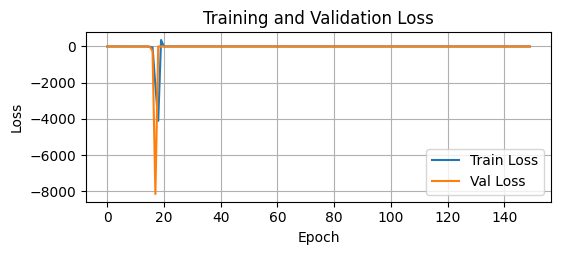

Minimum Validation Loss:  -8144.4757434475805


In [174]:
md.save_results(model, logs, cfg)
eval.plot_val_loss(logs['train_loss'],logs['val_loss'])
print("Minimum Validation Loss: ", min(logs['val_loss']))

In [163]:
train_loader.dataset.X.shape

torch.Size([578, 117, 32, 32])

In [169]:
for X_batch, y_batch, mask in train_loader:
    print(X_batch.shape)
    print(y_batch.shape)
    print(mask.shape)
    break

torch.Size([64, 120, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])


In [175]:
model, logs = md.train_model(model, train_loader, val_loader, cfg, md.global_config)

Epochs: 100%|██████████| 150/150 [02:16<00:00,  1.10it/s]


Results saved to: ../results/train/mid_level_learning


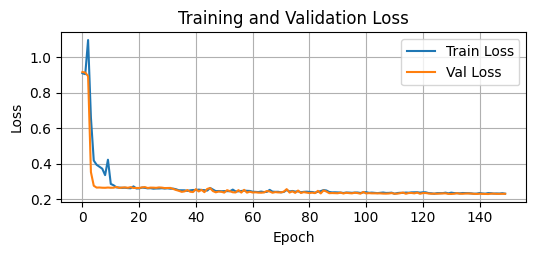

Minimum Validation Loss:  0.22883993050744456


In [176]:
md.save_results(model, logs, cfg)
eval.plot_val_loss(logs['train_loss'],logs['val_loss'])
print("Minimum Validation Loss: ", min(logs['val_loss']))